In [1]:
#Functions to be added
import pickle
import glob
import cv2

def get_num_classes(data_dir):
    """
    Get the number of classes.
    :param data_dir: str - data directory
    :return: int - number of classes
    """
    mode = 'training' # arbitrary
    loc = "{}/{}".format(data_dir, mode)
    with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
        data = pickle.load(f)

    modes = list(data.keys())

    assert glob.glob(data_dir), "Check directory."
    assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
    i = 0  # Arbitrarily chosen
    return len(data[modes[i]][i][-1])

def generate_img_label_from_folder(data_dir, mode, batch_size):
    """

    """
    loc = "{}/{}".format(data_dir, mode)
    while True:
        with open('{}/labels.pickle'.format(data_dir), 'rb') as f:
            data = pickle.load(f)

        modes = list(data.keys())
        del modes[-1]

        assert mode in modes, "'{}' not a valid mode (must be one of {})".format(mode, str(modes))
        assert glob.glob(loc), "Check directory."
        assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
        for idx in range(0, len(data[mode]), batch_size):
            start = idx
            end = idx + batch_size
            images, labels = read_n_images(data[mode], start, end, loc)
            yield (images/255, np.array(labels))

# Deep CNN
Here we can:
* Retrain the entire network with randomly initialized weights
* Train network with pre-trained encoder weights and randomly initialized FC layer weights(fine-tuning)
Reconstruction of images plotted at the end of notebook.

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
from shared.autoencoderHelpers import read_n_images, generate_img_from_folder, get_input_shape, get_num_examples, plot_history, get_images, bgr2rgb, plot_reconstruction

## Generate model(s)
* Encoder
* FFNN

**Set the layers for auto-encoder**

In [3]:
DATA_DIR = '../data'

In [4]:
autoencoder = tf.keras.models.load_model('../models/autoencoder/config2/model') 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

<img src="../CNN_schematic.png"  width= 30% align = right>

## Visual representation


Visual representation of what we are doing in Keras essentially.

We train the models in 3 distinct ways:
* Use model as a whole (CNN, green)
    * Initialize the weights randomly and train the whole model
    * Initialize the encoder layer weights as they are and train the whole model (fine tuning)
* Use model as an encoder (red) and classifier (blue)
    * Keep the encoder layer with the trained weights and initialize the classifier model weights randomly and train **only** the classifier model.

In [6]:
num_classes = get_num_classes(DATA_DIR)

layer_names = [autoencoder.layers[i].name for i in range(7)]
print("Layers of encoder:\n{}".format(layer_names))

encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[6].output)

for layer in encoder.layers:
    layer.trainable = False  # Set to true to allow fine-tuning

encoder_out = autoencoder.layers[6].output
flat = Flatten()(encoder.output)
x = Dense(2048, activation=tf.nn.relu, name='fc_1')(flat)
x = Dense(1024, activation=tf.nn.relu, name='fc_2')(x)
x = Dropout(rate=0.4, name='dropout')(x)
output_full_model = Dense(num_classes, activation=tf.nn.softmax, name='output_layer')(x) # Maybe sigmoid

clf_frozen = Model(inputs=encoder.inputs, outputs=output_full_model)

Layers of encoder:
['input_layer', 'enc_conv1', 'enc_max_pool1', 'enc_conv2', 'enc_max_pool2', 'enc_conv3', 'enc_max_pool3']
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
Total para

In [8]:
clf_frozen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

## Compile the model and get model summaries
Compiling only happens for `clf_model` model (as we are not training the encoder).

In [9]:
clf_frozen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training the frozen classifier
* Tune for batch size, number of epochs, etc.

In [10]:
batchSize = 8
epochs = 30

BATCH_SIZE_TRAIN = 10
NUM_SAMPLES_TRAIN = get_num_examples(DATA_DIR, 'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 10
NUM_SAMPLES_VAL = get_num_examples(DATA_DIR, 'validation')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 2

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = clf_frozen.fit_generator(generate_img_label_from_folder(DATA_DIR, 'training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=generate_img_label_from_folder(DATA_DIR, 'validation', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)


Epoch 1/2
162/162 [==============================] - 71s 436ms/step - loss: 4.6784 - acc: 0.7077 - val_loss: 4.8213 - val_acc: 0.6998
Epoch 2/2
162/162 [==============================] - 65s 401ms/step - loss: 4.6947 - acc: 0.7077 - val_loss: 4.8213 - val_acc: 0.6998


## Accessment of model perfomance
* Visualize the training history
* Generate predictions for auto-encoder (reconstructed images)
* Visualize original and reconstructed images (for comparison)

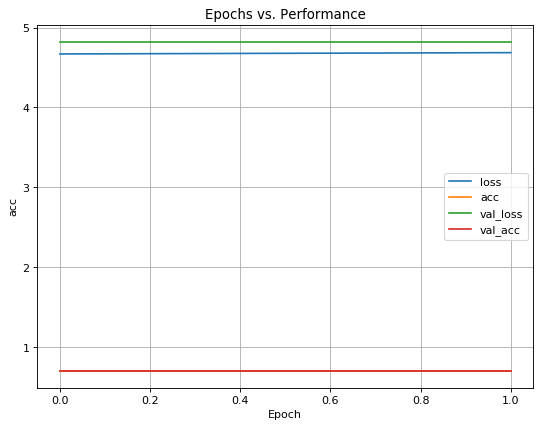

In [11]:
plot_history(history)

In [12]:
#Decoding images
BATCH_SIZE_TEST = 10
NUM_SAMPLES_TEST = get_num_examples(DATA_DIR, 'test')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

evaluation = clf_frozen.evaluate_generator(generate_img_label_from_folder(DATA_DIR, 'test', BATCH_SIZE_TEST),steps=STEPS_TEST)

In [13]:
print("The test set after {} epochs:\nLoss: {}\nAccuracy: {}".format(EPOCHS, evaluation[0], evaluation[-1]))

The test set after 2 epochs:
Loss: 4.8704644883120505
Accuracy: 0.6960893869400024


## Melted classifier

In [14]:
in_shape = get_input_shape(DATA_DIR, 'training')
clf_melted = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', name='enc_conv1', input_shape=in_shape),
    MaxPooling2D((2, 2), padding='same', name='enc_max_pool1'),
    Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv2'),
    MaxPooling2D((2, 2), padding='same', name='enc_max_pool2'),
    Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv3'),
    MaxPooling2D((2, 2), padding='same', name='enc_max_pool3'),
    Flatten(),
    Dense(2048, activation=tf.nn.relu, name='fc_1'),
    Dense(1024, activation=tf.nn.relu, name='fc_2'),
    Dropout(rate=0.4, name='dropout'),
    Dense(num_classes, activation=tf.nn.softmax, name='output_layer') # Maybe sigmoid
])
clf_melted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Same as before, but all parameters are trainable
clf_melted.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
__________

## Training the classifier
* Tune for batch size, number of epochs, etc.

In [16]:
batchSize = 8
epochs = 30

BATCH_SIZE_TRAIN = 10
NUM_SAMPLES_TRAIN = get_num_examples(DATA_DIR, 'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 10
NUM_SAMPLES_VAL = get_num_examples(DATA_DIR, 'validation')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 2

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = clf_melted.fit_generator(generate_img_label_from_folder(DATA_DIR, 'training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=generate_img_label_from_folder(DATA_DIR, 'validation', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)


Epoch 1/2
162/162 [==============================] - 97s 601ms/step - loss: 0.5470 - acc: 0.7904 - val_loss: 0.4744 - val_acc: 0.7974
Epoch 2/2
162/162 [==============================] - 95s 589ms/step - loss: 0.4544 - acc: 0.8036 - val_loss: 0.6494 - val_acc: 0.7359


## Accessment of model perfomance
* Visualize the training history
* Generate predictions for auto-encoder (reconstructed images)
* Visualize original and reconstructed images (for comparison)

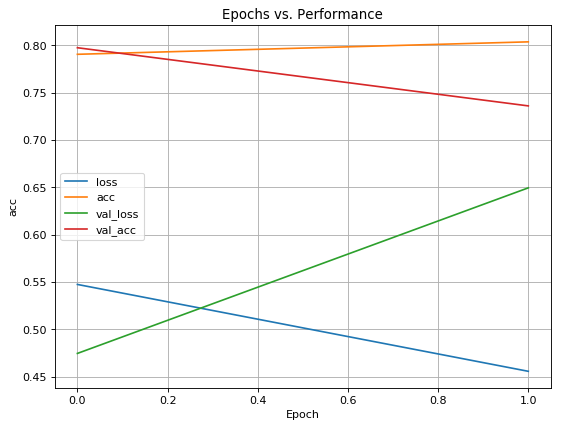

In [17]:
plot_history(history)

In [18]:
#Decoding images
BATCH_SIZE_TEST = 10
NUM_SAMPLES_TEST = get_num_examples(DATA_DIR, 'test')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

evaluation = clf_melted.evaluate_generator(generate_img_label_from_folder(DATA_DIR, 'test', BATCH_SIZE_TEST),steps=STEPS_TEST)

In [19]:
print("The test set after {} epochs:\nLoss: {}\nAccuracy: {}".format(EPOCHS, evaluation[0], evaluation[-1]))

The test set after 2 epochs:
Loss: 0.6628557173190294
Accuracy: 0.7281191945075989
